In [2]:
import numpy as np
import imutils
import cv2

class Panaroma:

    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=4.0,match_status=False):#接收两个图像作为输入，使用 SIFT 算法检测它们的特征和关键点，然后匹配这些特征点以找到它们之间的对应关系。


        (imageB, imageA) = images
        (KeypointsA, features_of_A) = self.Detect_Feature_And_KeyPoints(imageA)
        (KeypointsB, features_of_B) = self.Detect_Feature_And_KeyPoints(imageB)
        # 根据输入的特征点匹配计算两个图像之间的变换矩阵。
        Values = self.matchKeypoints(KeypointsA, KeypointsB,features_of_A, features_of_B, lowe_ratio, max_Threshold)

        if Values is None:
            return None


        (matches, Homography, status) = Values
        result_image = self.getwarp_perspective(imageA,imageB,Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB#把扭曲过后的图片左边B大小的区域都赋值给B


        if match_status:#如果匹配成功
            vis = self.draw_Matches(imageA, imageB, KeypointsA, KeypointsB, matches,status)

            return (result_image, vis)

        return result_image

    def getwarp_perspective(self,imageA,imageB,Homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, Homography, (val , imageA.shape[0]))
#将图像 A 通过变换矩阵 Homography 转换为与图像AB宽度相加高度相等的图像。
        return result_image

    def Detect_Feature_And_KeyPoints(self, image):#用于检测输入图像的 SIFT 特征和关键点
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptors = cv2.SIFT_create()
        (Keypoints, features) = descriptors.detectAndCompute(image, None)

        Keypoints = np.float32([i.pt for i in Keypoints])
        return (Keypoints, features)

    def get_Allpossible_Match(self,featuresA,featuresB):#用于计算两个图像之间所有可能的特征点匹配。

        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)

        return All_Matches

    def All_validmatches(self,AllMatches,lowe_ratio):#根据 Lowe 的比率测试选出所有有效的特征点匹配。
        valid_matches = []

        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))

        return valid_matches

    def Compute_Homography(self,pointsA,pointsB,max_Threshold):#使用 RANSAC 算法计算两个图像之间的变换矩阵。

        (H, status) = cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)
        return (H,status)

    def matchKeypoints(self, KeypointsA, KeypointsB, featuresA, featuresB,lowe_ratio, max_Threshold):#根据输入的特征点匹配计算两个图像之间的变换矩阵。

        AllMatches = self.get_Allpossible_Match(featuresA,featuresB);#用于计算两个图像之间所有可能的特征点匹配。
        valid_matches = self.All_validmatches(AllMatches,lowe_ratio)#根据 Lowe 的比率测试选出所有有效的特征点匹配。

        if len(valid_matches) > 4:#如果有效的特征点匹配数量大于 4，
    
            pointsA = np.float32([KeypointsA[i] for (_,i) in valid_matches])
            pointsB = np.float32([KeypointsB[i] for (i,_) in valid_matches])
#max_Threshold 是 RANSAC 算法中的距离阈值，用于筛选出好的匹配点。
            (Homograpgy, status) = self.Compute_Homography(pointsA, pointsB, max_Threshold)
# Compute_Homography 函数，计算出两个图像之间的变换矩阵，并返回变换矩阵 Homography 和状态 status。
            return (valid_matches, Homograpgy, status)#将有效的特征点匹配、变换矩阵和状态作为结果返回
        else:
            return None

    def get_image_dimension(self,image):#获取图像的高度和宽度。
        (h,w) = image.shape[:2]
        return (h,w)

    def get_points(self,imageA,imageB):#将两个图像水平拼接以创建一个大图像。

        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        return vis


    def draw_Matches(self, imageA, imageB, KeypointsA, KeypointsB, matches, status):#将特征点匹配可视化。

        (hA,wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA,imageB)


        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
                ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        return vis


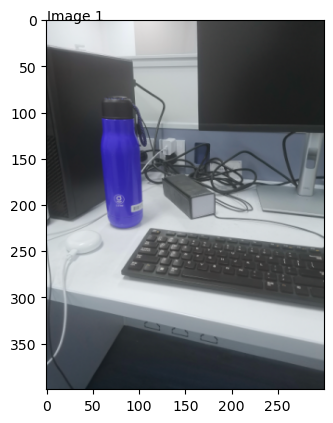

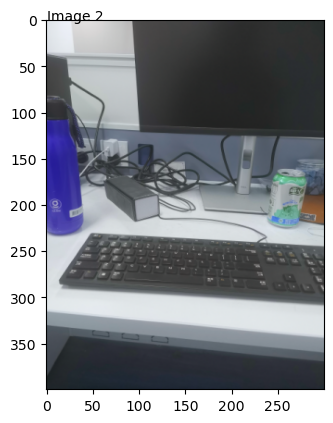

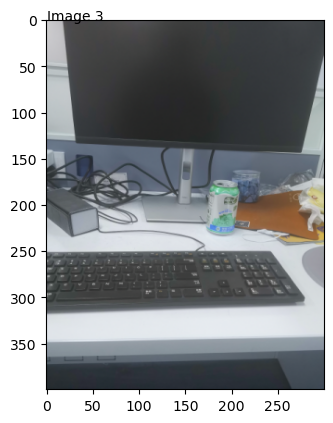

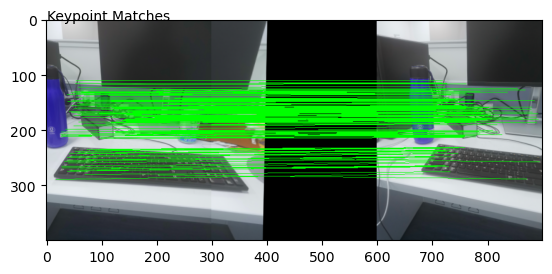

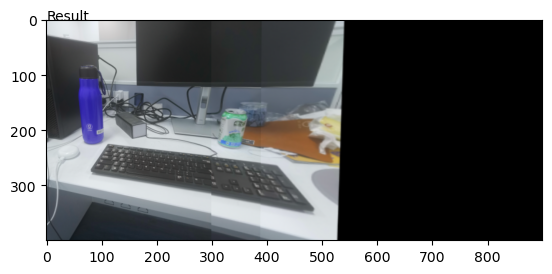

In [17]:
from matplotlib import pyplot as plt

no_of_images = 3#定义的读取图片的数量


filename = ['image_1.jpg', 'image_2.jpg', 'image_3.jpg']#设置的图片的地址

images = []#存储原始图片
#读取图像并进行标准化
for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)
#。如果要拼接的图像数为2，则调用“image_stitch”函数将它们拼接在一起。
# 如果图像数量大于2，则先将最后两个图像拼接在一起，然后对于剩下的所有图像，循环地将它们与先前拼接的结果拼接在一起。
panaroma = Panaroma()
if no_of_images==2:
    (result, matched_points) = panaroma.image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panaroma.image_stitch([images[no_of_images-2], images[no_of_images-1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panaroma.image_stitch([images[no_of_images-i-3],result], match_status=True)

#可视化图片
for i in range(no_of_images):
    plt.text(0, 0, "Image {k}".format(k=i+1))
    plt.imshow( images[i])
    plt.show()
plt.text(0, 0, "Keypoint Matches")
plt.imshow( matched_points)
plt.show()
plt.text(0,0, "Result")
plt.imshow( result)
plt.show()
#存储图片
cv2.imwrite("Matched_points.jpg",matched_points)
cv2.imwrite("Panorama_image.jpg",result)

cv2.waitKey(0)
cv2.destroyAllWindows()
